In [36]:
import pandas as pd
df_train = pd.read_csv('Final Dataset/@final_training_ndvi_prediction.csv')


In [37]:
nan_cols = df_train.columns[df_train.isna().any()].tolist()

print("Các cột có NaN trong df_val:")
for col in nan_cols:
    print(f"{col}: {df_train[col].isna().sum()} NaN")


Các cột có NaN trong df_val:
ndvi_mean_lag1: 133 NaN
ndvi_mean_lag2: 266 NaN
ndvi_mean_lag3: 399 NaN
ndvi_mean_roll3_mean: 133 NaN
ndvi_mean_roll3_std: 266 NaN
ndvi_mean_roll3_min: 133 NaN
ndvi_mean_roll3_max: 133 NaN
ndvi_mean_exp_mean: 133 NaN
ndvi_mean_exp_std: 266 NaN


In [38]:
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# 1. Cột NDVI cần impute
ndvi_cols = [
    "ndvi_mean_lag1",
    "ndvi_mean_lag2",
    "ndvi_mean_lag3",
    "ndvi_mean_roll3_mean",
    "ndvi_mean_roll3_std",
    "ndvi_mean_roll3_min",
    "ndvi_mean_roll3_max",
    "ndvi_mean_exp_mean",
    "ndvi_mean_exp_std",
]

target_col = "next_16day_ndvi_mean"

# 2. Các cột KHÔNG dùng cho imputation
drop_cols = ["NAME_1", "NAME_2", "GID_1", target_col]

feature_for_impute = [
    c for c in df_train.columns
    if c not in drop_cols and c != "GID_2"
]

cols_for_impute = ndvi_cols + [
    c for c in feature_for_impute if c not in ndvi_cols
]

df_train_imp = df_train.copy()
imputers_by_gid = {}  # lưu imputer cho từng huyện

for gid, group in df_train_imp.groupby("GID_2"):
    g = group.copy()

    data = g[cols_for_impute].replace([np.inf, -np.inf], np.nan)

    # Nếu tất cả NDVI trong huyện đều NaN cho 1 cột nào đó → dùng global mean
    for col in ndvi_cols:
        if data[col].isna().all():
            global_mean = df_train[col].mean()
            data[col] = data[col].fillna(global_mean)

    imputer = IterativeImputer(
        estimator=RandomForestRegressor(
            n_estimators=200,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        ),
        max_iter=15,
        random_state=42
    )

    imputed_array = imputer.fit_transform(data)
    imputed_df = pd.DataFrame(imputed_array, columns=cols_for_impute, index=g.index)

    # Gán lại NDVI đã impute vào train
    df_train_imp.loc[g.index, ndvi_cols] = imputed_df[ndvi_cols]

    # Lưu imputer để lát nữa dùng cho val/test
    imputers_by_gid[gid] = imputer

print("NaN trong NDVI (train) sau impute:")
print(df_train_imp[ndvi_cols].isna().sum())


NaN trong NDVI (train) sau impute:
ndvi_mean_lag1          0
ndvi_mean_lag2          0
ndvi_mean_lag3          0
ndvi_mean_roll3_mean    0
ndvi_mean_roll3_std     0
ndvi_mean_roll3_min     0
ndvi_mean_roll3_max     0
ndvi_mean_exp_mean      0
ndvi_mean_exp_std       0
dtype: int64


In [39]:
def apply_group_imputer(df_in, imputers_by_gid, cols_for_impute, ndvi_cols):
    """
    df_in:   df_val hoặc df_test (chưa impute)
    imputers_by_gid: dict {gid: IterativeImputer đã fit trên train của gid đó}
    cols_for_impute: list các cột được đưa vào imputer (ndvi_cols + feature predictor)
    ndvi_cols:       các cột NDVI cần điền khuyết
    """
    df_out = df_in.copy()
    
    for gid, group in df_out.groupby("GID_2"):
        g = group.copy()
        
        # lấy đúng các cột cần đưa qua imputer
        data = g[cols_for_impute].replace([np.inf, -np.inf], np.nan)

        if gid in imputers_by_gid:
            imputer = imputers_by_gid[gid]
            imputed_array = imputer.transform(data)
            imputed_df = pd.DataFrame(
                imputed_array,
                columns=cols_for_impute,
                index=g.index
            )
            # chỉ ghi đè lại các cột NDVI
            df_out.loc[g.index, ndvi_cols] = imputed_df[ndvi_cols]
        else:
            # huyện xuất hiện ở val/test nhưng không có trong train
            # fallback: fill mean theo group hiện tại
            data_filled = data.copy()
            for col in ndvi_cols:
                if data_filled[col].isna().all():
                    # nếu cả group toàn NaN → dùng global mean từ df_in
                    global_mean = df_in[col].mean()
                    data_filled[col] = data_filled[col].fillna(global_mean)
                else:
                    data_filled[col] = data_filled[col].fillna(data_filled[col].mean())
            
            df_out.loc[g.index, ndvi_cols] = data_filled[ndvi_cols]

    return df_out


In [40]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models

def build_ann_with_gid_embedding(n_features, n_regions):
    l2_reg = 0.01
    dropout_rate = 0.2

    # ----- INPUT 1: weather + NDVI features -----
    feat_input = layers.Input(shape=(n_features,), name="features")

    x = layers.Dense(250, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(feat_input)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(200, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(150, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)

    # ----- INPUT 2: GID_2 embedding -----
    region_input = layers.Input(shape=(1,), dtype="int32", name="gid2")
    region_emb = layers.Embedding(input_dim=n_regions,
                                  output_dim=16)(region_input)
    region_emb = layers.Flatten()(region_emb)
    region_emb = layers.Dense(16, activation='relu')(region_emb)

    # ----- MERGE -----
    merged = layers.Concatenate()([x, region_emb])

    y = layers.Dense(100, activation='relu')(merged)
    y = layers.Dropout(dropout_rate)(y)
    y = layers.Dense(50, activation='relu')(y)
    y = layers.Dropout(dropout_rate)(y)
    y = layers.Dense(25, activation='relu')(y)
    y = layers.Dense(10, activation='relu')(y)

    output = layers.Dense(1, activation='linear')(y)

    model = models.Model(inputs=[feat_input, region_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
    )

    return model


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf

# ===== 0. Load dữ liệu =====
df_train = df_train_imp.copy()
df_val_raw   = pd.read_csv("Final Dataset/@final_validation_ndvi_prediction.csv")
df_test_raw  = pd.read_csv("Final Dataset/@final_testing_ndvi_prediction.csv")

# ===== 0.1. Áp dụng group imputer lên VAL & TEST =====
df_val  = apply_group_imputer(df_val_raw,  imputers_by_gid, cols_for_impute, ndvi_cols)
df_test = apply_group_imputer(df_test_raw, imputers_by_gid, cols_for_impute, ndvi_cols)

print("NaN NDVI (val) :", df_val[ndvi_cols].isna().sum())
print("NaN NDVI (test):", df_test[ndvi_cols].isna().sum())

# ===== 1. Chuẩn bị cột =====
drop_cols = ['NAME_1', 'GID_1', 'NAME_2', 'year']  # nếu có start_date/end_date thì thêm luôn vào đây
target_col = 'next_16day_ndvi_mean'

feature_cols = [
    c for c in df_train.columns
    if c not in drop_cols + [target_col, 'GID_2']
]

# ===== 2. Mapping GID_2 nhất quán giữa train/val/test =====
gid_categories = df_train['GID_2'].astype('category').cat.categories

df_train['GID_2_code'] = pd.Categorical(df_train['GID_2'],
                                        categories=gid_categories).codes
df_val['GID_2_code']   = pd.Categorical(df_val['GID_2'],
                                        categories=gid_categories).codes
df_test['GID_2_code']  = pd.Categorical(df_test['GID_2'],
                                        categories=gid_categories).codes

# ===== 3. Tách X_num, X_gid, y =====
# Train
X_num_train = df_train[feature_cols].values.astype("float32")
X_gid_train = df_train['GID_2_code'].values.astype("int32")
y_train     = df_train[target_col].values.astype("float32")

# Val
X_num_val = df_val[feature_cols].values.astype("float32")
X_gid_val = df_val['GID_2_code'].values.astype("int32")
y_val     = df_val[target_col].values.astype("float32")

# Test
X_num_test = df_test[feature_cols].values.astype("float32")
X_gid_test = df_test['GID_2_code'].values.astype("int32")
y_test     = df_test[target_col].values.astype("float32")

# ===== 4. Chuẩn hoá numeric features (fit trên train, apply cho val/test) =====
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_val_scaled   = scaler.transform(X_num_val)
X_num_test_scaled  = scaler.transform(X_num_test)



In [49]:
# ===== 5. Build model với embedding cho huyện =====
n_regions = len(gid_categories)
model = build_ann_with_gid_embedding(
    n_features=X_num_train_scaled.shape[1],
    n_regions=n_regions,
)

# ===== 6. Early stopping =====
callback_es = tf.keras.callbacks.EarlyStopping(
    monitor='val_rmse',
    patience=20,
    restore_best_weights=True
)

# ===== 7. Train =====
history = model.fit(
    {"features": X_num_train_scaled, "gid2": X_gid_train},
    y_train,
    validation_data=(
        {"features": X_num_val_scaled, "gid2": X_gid_val},
        y_val
    ),
    epochs=200,
    batch_size=64,
    callbacks=[callback_es],
    verbose=1
)
# ===== 7b. Đánh giá trên validation (MSE, RMSE) =====
val_loss, val_rmse = model.evaluate(
    {"features": X_num_val_scaled, "gid2": X_gid_val},
    y_val,
    verbose=0
)
print("Val loss (MSE):", val_loss)
print("Val RMSE:", val_rmse)

# ===== 7c. Tính R² trên validation =====
def r2_score_np(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - ss_res / ss_tot if ss_tot != 0 else np.nan

y_pred_val = model.predict(
    {"features": X_num_val_scaled, "gid2": X_gid_val},
    verbose=0
).flatten()

r2_val = r2_score_np(y_val, y_pred_val)
print("Val R²:", r2_val)

# ===== 8. Đánh giá trên test (MSE, RMSE) =====
test_loss, test_rmse = model.evaluate(
    {"features": X_num_test_scaled, "gid2": X_gid_test},
    y_test,
    verbose=0
)
print("Test loss (MSE):", test_loss)
print("Test RMSE:", test_rmse)

# ===== 9. Tính R² trên test =====
def r2_score_np(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - ss_res / ss_tot if ss_tot != 0 else np.nan

y_pred_test = model.predict(
    {"features": X_num_test_scaled, "gid2": X_gid_test},
    verbose=0
).flatten()

r2_test = r2_score_np(y_test, y_pred_test)
print("Test R²:", r2_test)


Epoch 1/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.9282 - rmse: 0.4109 - val_loss: 4.6369 - val_rmse: 0.2964
Epoch 2/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5609 - rmse: 0.2864 - val_loss: 4.3384 - val_rmse: 0.2589
Epoch 3/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2684 - rmse: 0.2539 - val_loss: 4.0629 - val_rmse: 0.2429
Epoch 4/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9940 - rmse: 0.2352 - val_loss: 3.7957 - val_rmse: 0.2244
Epoch 5/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7304 - rmse: 0.2194 - val_loss: 3.5428 - val_rmse: 0.2177
Epoch 6/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4769 - rmse: 0.2058 - val_loss: 3.2966 - val_rmse: 0.2049
Epoch 7/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2359 - rmse: 0.1996 - val_loss: 3.0612 - val_rmse: 0.1951
Epoch 8/200
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.0028 - rmse: 0.1896 - val_loss: 2.8357 - val_rmse: 0.1872
Epoch 9/200
342/342 ━━━━━━━━━━━━

In [ ]:
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 54)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 250)       │     13,750 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 250)       │          0 │ dense_27[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 200)       │     50,200 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gid2 (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 200)       │          0 │ dense_28[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 16)     │      2,128 │ gid2[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 150)       │     30,150 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 16)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 150)       │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 16)        │        272 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 166)       │          0 │ dropout_17[0][0], │
│ (Concatenate)       │                   │            │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 100)       │     16,700 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 100)       │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 50)        │      5,050 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 50)        │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 25)        │      1,275 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 10)        │        260 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1)         │         11 │ dense_34[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 359,390 (1.37 MB)

 Trainable params: 119,796 (467.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 239,594 (935.92 KB)

In [44]:
import matplotlib.pyplot as plt


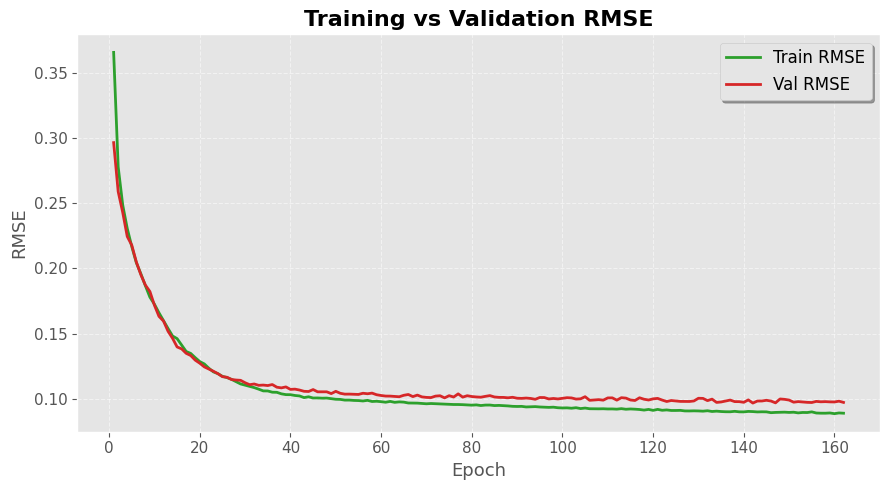

In [54]:
train_rmse = history.history["rmse"]
val_rmse = history.history["val_rmse"]
epochs = np.arange(1, len(train_rmse) + 1)

plt.figure(figsize=(9,5))
plt.plot(epochs, train_rmse, label="Train RMSE", color="#2ca02c", linewidth=2)
plt.plot(epochs, val_rmse, label="Val RMSE", color="#d62728", linewidth=2)

plt.title("Training vs Validation RMSE", fontsize=16, fontweight='bold')
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("RMSE", fontsize=13)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12, frameon=True, shadow=True)

plt.tight_layout()
plt.show()


In [ ]:
model.save("ndvi_ann_model.h5")
